#Image Recolouring Project

Project developed by Alejandro Cano Caldero and Jesús Moncada Ramírez for the subject <i>Neural Networks and Deep Learning</i>, University of Padova, 2022-23.


In [63]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
!pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Import necessary libraries for our project.
import numpy as np

import torch

import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torchvision.transforms import transforms

from torch.utils.data import DataLoader, Dataset  

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as op

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

from torch import autograd

In [66]:
# Define the execution device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
# Mount in Google Drive. 
# Only execute if running in Google Colab and the dataset is on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Dataset

The dataset we have used is [ImageNette](https://github.com/fastai/imagenette), a reduced version of ImageNet, the full size images version.

<code>ImageDataset</code> is a default dataset class for images . To create an instance of this class you have to specify the route of the image folder (<code>image_path</code>) and a list of transforms (<code>transforms</code>). The constructor parameters <code>first</code> and <code>last</code> allow using a subset of the complete dataset specified in the path (as in our case). Anyway, the whole dataset is loaded, but only these elements will be available. 

Basically it is an adapted version of <code>torchvision.datasets.ImageFolder</code>. Note that only returns one image when accessing to an element in <code>\_\_getitem\_\_</code>.

In [20]:
class ImageDataset(Dataset):
  def __init__(self, image_path, transform=None, first=0, last=499):
    super(ImageDataset, self).__init__()
    self.data = datasets.ImageFolder(image_path,  transform)
    self.first = first
    self.last = last

  def __getitem__(self, idx):
    x, y = self.data[self.first + idx]
    return x

  def __len__(self):
    return self.last-self.first + 1

<code>TwoImagesDataset</code> is a dataset class combining two images datasets. We will use this class to create a dataset with tuples containing two versions of the same image, the first element will be the grayscale version (input image) and the second element will be the colored version (target image).

In [21]:
class TwoImagesDataset(Dataset):
  def __init__(self, dataset1, dataset2):
    super(TwoImagesDataset, self).__init__()
    self.dataset1 = dataset1
    self.dataset2 = dataset2
    if len(self.dataset1) != len(self.dataset2):
      print('ERROR, len of dataset1 is different from len of dataset2')

  def __getitem__(self, idx):
    return self.dataset1[idx], self.dataset2[idx]

  def __len__(self):
    return len(self.dataset1)

After defining the data structures, we will create a dataset class with all the images resized to <code>256 x 256</code> (<code>colored_data</code>) and a dataset class with all the images resized to <code>256 x 256</code> in grayscale (<code>grayscale_data</code>). By last we will create the dataset class containing both kind of images (<code>dataset</code>), that will be used for training. In our case, we have decided it to have 500 samples.

We will also create a test dataset with 150 samples (30% of the training dataset), <code>dataset_test</code>.

In [75]:
# If locating the dataset in Google Drive
img_path_train = 'drive/MyDrive/imagenette2/train'
img_path_test = 'drive/MyDrive/imagenette2/val'

# Define normalization [0, 255] --> [-1, 1] (Owing to the use of the tanh activation function)

colored_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)) # resize to (256, 256)
     ] )

grayscale_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)), # resize to (256, 256)
     transforms.Grayscale(3) # to grayscale
     ])

# TRAINING SET 500 samples
colored_data = ImageDataset(img_path_train, colored_transform, first=0, last=499)
grayscale_data = ImageDataset(img_path_train, grayscale_transform, first=0, last=499)
dataset = TwoImagesDataset(grayscale_data, colored_data)

# TEST SET 150 samples (30% of training samples)
colored_data_test = ImageDataset(img_path_test, colored_transform, first=0, last=149)
grayscale_data_test = ImageDataset(img_path_test, grayscale_transform, first=0, last=149)
dataset_test = TwoImagesDataset(colored_data_test, grayscale_data_test)

In [23]:
print("Number of images in our training dataset is: {0}".format(len(dataset)))
print("Number of images in our test dataset is: {0}".format(len(dataset_test)))

Number of images in our training dataset is: 10
Number of images in our test dataset is: 150


To check everything was ok let's show (with a new function <code>plot_image</code>) the colored and the grayscale version of the same image.

Plotting a grayscale image in the dataset:


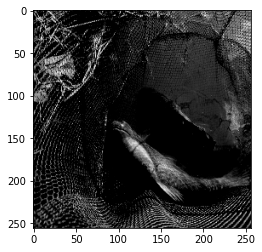

In [24]:
def plot_image(img):
  plt.imshow(img.permute(1, 2, 0))

grayscale_img, colored_img  = dataset[0]

print('Plotting a grayscale image in the dataset:')
plot_image(grayscale_img)

Plotting a colored image in the dataset:


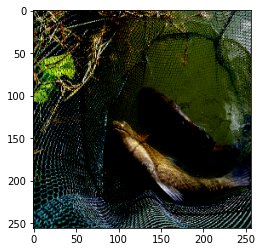

In [25]:
print('Plotting a colored image in the dataset:')
plot_image(colored_img)

We will also create a function to show images where each element takes value from -1 to 1, <code>plot_image_minus1to1</code>.

In [26]:
def plot_image_minus1to1(image):
  plot_image((image + 1) / 2)

We need a <code>DataLoader</code> instance for our dataset in order to get the images as batchs for the training phase. The <code>batch_size</code> will be 1 as said in the paper. We will also create a dataloader for the test data.

In [76]:
dataloader = DataLoader(dataset, batch_size=1)

dataloader_test = DataLoader(dataset_test, batch_size=1)

##2. Discriminator

The discriminator used (called PatchGAN) takes as input an image of <code>(256x256)</code> and returns a tensor of <code>(30x30)</code>. The discriminator class is the following:

In [53]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2_bn = nn.BatchNorm2d(128)
        self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=kernel_size, stride=2, padding=1)
        self.layer3_bn = nn.BatchNorm2d(256)
        self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=kernel_size, padding=1) # stride = 1
        self.layer4_bn = nn.BatchNorm2d(512)
        self.layer5 = nn.Conv2d(512, out_channels=1, kernel_size=kernel_size, padding=1)
        
        # Weight initialization
        torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)

    def forward(self, x, verbose=False):
        d = F.leaky_relu(self.layer1(x), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer2_bn(self.layer2(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer3_bn(self.layer3(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer4_bn(self.layer4(d)), 0.2)
        if verbose:
          print(d.shape)
        d = self.layer5(d)
        if verbose:
          print(d.shape)

        return torch.sigmoid(d)

Let's create an object for the discriminator, and its Adam optimizer.

In [ ]:
discriminator = Discriminator(in_channels=6, kernel_size=4)
discriminator.to(device)

discriminator_optimizer = op.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.5)

And let's execute the discriminator forward pass on a pair of images concatenated from the dataset to check if it works.

In [ ]:
input_img, target_img = dataset[0]

input_img = input_img.unsqueeze(0)
target_img = target_img.unsqueeze(0)
# unsqueeze(0) needed to get batch_size = 1

disc_input = torch.cat((input_img, target_img), dim=1) # discriminator input

print("Shape of discriminator input: {0}".format(disc_input.shape))

out = discriminator.forward(disc_input) # forward pass discriminator

print("Shape of discriminator output: {0}".format(out.shape))

Shape of discriminator input: torch.Size([1, 6, 256, 256])
Shape of discriminator output: torch.Size([1, 1, 30, 30])


##3. Generator

The generator used has an autoencoder style, with both encoder and decoder networks. The input and the output are images. It uses a UNET Generator, with skip connections.The generator class is the following:

In [28]:
class Generator(nn.Module):
  def __init__(self, in_channels, stride=1):
    super().__init__()

    # ----------------------------- ENCODER ----------------------------
    #            ENCODER MODEL: C64-C128-C256-C512-C512-C512-C512
    self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer2_bn = nn.BatchNorm2d(128)
    self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer3_bn = nn.BatchNorm2d(256)
    self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer4_bn = nn.BatchNorm2d(512)
    self.layer5 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer5_bn = nn.BatchNorm2d(512)
    self.layer6 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer6_bn = nn.BatchNorm2d(512)
    self.layer7 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer7_bn = nn.BatchNorm2d(512)

    # ----------------------------- BOTTLENECK ----------------------------
    self.bottleneck_layer = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)

    # ----------------------------- DECODER ----------------------------
    #           DECODER MODEL: CD512-CD512-CD512-CD512-CD256-CD128-CD64
    self.layer8 = nn.ConvTranspose2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer8_bn = nn.BatchNorm2d(512)
    self.layer8_dpout = nn.Dropout()
    self.layer9 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer9_bn = nn.BatchNorm2d(512)
    self.layer9_dpout = nn.Dropout()
    self.layer10 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer10_bn = nn.BatchNorm2d(512)
    self.layer10_dpout = nn.Dropout()
    self.layer11 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer11_bn = nn.BatchNorm2d(512)
    self.layer12 = nn.ConvTranspose2d(1024, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer12_bn = nn.BatchNorm2d(256)
    self.layer13 = nn.ConvTranspose2d(512, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer13_bn = nn.BatchNorm2d(128)
    self.layer14 = nn.ConvTranspose2d(256, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer14_bn = nn.BatchNorm2d(64)

    # ----------------------------- OUTPUT ----------------------------
    self.layer15 = nn.ConvTranspose2d(128, out_channels=3, kernel_size=4, stride=2, padding=1)

    # Weight initialization
    torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer6.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer7.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.bottleneck_layer.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer8.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer9.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer10.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer11.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer12.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer13.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer14.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer15.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer5_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer5_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer6_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer6_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer7_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer7_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer8_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer8_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer9_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer9_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer10_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer10_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer11_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer11_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer12_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer12_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer13_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer13_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer14_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer14_bn.bias.data, 0.0)

  def forward(self, x, verbose=False):

    # ----------------------------- ENCODER ----------------------------
    e1 = F.leaky_relu(self.layer1(x), 0.2)
    if verbose:
      print(e1.shape)
    e2 = F.leaky_relu(self.layer2_bn(self.layer2(e1)), 0.2)
    if verbose:
      print(e2.shape)
    e3 = F.leaky_relu(self.layer3_bn(self.layer3(e2)), 0.2)
    if verbose:
      print(e3.shape)
    e4 = F.leaky_relu(self.layer4_bn(self.layer4(e3)), 0.2)
    if verbose:
      print(e4.shape)
    e5 = F.leaky_relu(self.layer5_bn(self.layer5(e4)), 0.2)
    if verbose:
      print(e5.shape)
    e6 = F.leaky_relu(self.layer6_bn(self.layer6(e5)), 0.2)
    if verbose:
      print(e6.shape)
    e7 = F.leaky_relu(self.layer7_bn(self.layer7(e6)), 0.2) 
    if verbose:
      print(e7.shape)

    # ----------------------------- BOTTLENECK ----------------------------
    b = F.relu(self.bottleneck_layer(e7))
    if verbose:
      print(b.shape)

    # ----------------------------- DECODER ----------------------------
    d1 = F.relu(torch.cat((self.layer8_dpout(self.layer8_bn(self.layer8(b))), e7), 1))
    if verbose:
      print(d1.shape)
    d2 = F.relu(torch.cat((self.layer9_dpout(self.layer9_bn(self.layer9(d1))), e6), 1))
    if verbose:
      print(d2.shape)
    d3 = F.relu(torch.cat((self.layer10_dpout(self.layer10_bn(self.layer10(d2))), e5), 1))
    if verbose:
      print(d3.shape)
    d4 = F.relu(torch.cat(((self.layer11_bn(self.layer11(d3))), e4), 1))
    if verbose:
      print(d4.shape)
    d5 = F.relu(torch.cat(((self.layer12_bn(self.layer12(d4))), e3), 1))
    if verbose:
      print(d5.shape)
    d6 = F.relu(torch.cat(((self.layer13_bn(self.layer13(d5))), e2), 1))
    if verbose:
      print(d6.shape)
    d7 = F.relu(torch.cat(((self.layer14_bn(self.layer14(d6))), e1), 1))
    if verbose:
      print(d7.shape)

    # ----------------------------- OUTPUT ----------------------------
    o = torch.tanh(self.layer15(d7))

    return o

Let's create an object for the generator, and its Adam optimizer.

In [ ]:
generator = Generator(3)
generator.to(device)

generator_optimizer = op.Adam(generator.parameters(), lr=0.0002, weight_decay=0.5)

And let's execute the generator forward pass on an images from the dataset to check if it works.

Shape of generator input: torch.Size([1, 3, 256, 256])
Shape of generator output: torch.Size([1, 3, 256, 256]) 


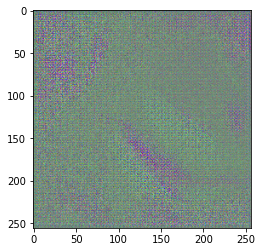

In [ ]:
input_img, tg_img = dataset[0]
input = input_img.unsqueeze(0)

print("Shape of generator input: {0}".format(input.shape))

out = generator.forward(input)

print("Shape of generator output: {0} ".format(out.shape))

out = out.detach()
plot_image_minus1to1(out[0])

##4. Loss functions

For the loss function, we are going to use the **Binary Cross-Entropy** loss and the **L1** loss.

In [29]:
adversarial_loss = nn.BCELoss(weight=torch.tensor(0.5))
l1_loss = nn.L1Loss()

Four parameters are fed to the <code>generator_loss</code> function:

1. <code>generator_image</code>: Images produced by the generator
2. <code>target_image</code>: Ground-truth pair image for the input fed to the generator.
3. <code>discriminator_predictions</code>: Output predictions from the discriminator, when fed with generator-produced images.
4. <code>real_target</code>: Ground-truth labels (1), as you would like the generator to produce real images by fooling the discriminator. The labels therefore would be one.

In [30]:
def generator_loss(generator_image, target_image, discriminator_predictions, real_target):
  gen_loss = adversarial_loss(discriminator_predictions, real_target)
  l1_l = l1_loss(generator_image, target_image)
  result = gen_loss + (100 * l1_l)

  return result

The <code>discriminator_loss</code> function has 2 arguments:

1. <code>output</code>: Output of the discriminator for a pair of images as input.
2. <code>label</code>: Expected output for the discriminator, a tensor full of 0's (in case of fake images) or a tensor full of 1's (in case of true images).

In [31]:
def discriminator_loss(output, label):
  return adversarial_loss(output, label)

##5. Training

First of all let's create some functions to save and load the models (generators and discriminator) trained.

In [56]:
def save_model(model, path, verbose=False):
  torch.save(model.state_dict(), path)
  if verbose:
    print('Saved model '+path)

def load_model(model, path, verbose=False):
  # model must match with the saved data in path
  if verbose:
    print('Loading model '+path)
  return model.load_state_dict(torch.load(path))

The training phase for our model will be the following. Note <code>num_epochs</code> has been set to 1 in order to test everything, but should be a higher value. The training losses (from generator and discriminator) obtained at each batch processed will be saved into two list, in order to plot them later.

In [ ]:
# Info to save the models
generator_model_path = "drive/MyDrive/models/generatorModelImageColoring.pth"
discriminator_model_path = "drive/MyDrive/models/discriminatorModelImageColoring.pth"

# Number of epochs
num_epochs = 10 

# Count
cnt = 1

# List of generator losses
generator_losses = list()
# List of discriminator losses
discriminator_losses = list()

for epoch in range(1, num_epochs + 1):

  for (input_img, tg_img) in dataloader:

    discriminator_optimizer.zero_grad()

    # Put input and target image into device.
    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    # Ground truth labels real and fake
    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    # Generator forward pass
    generated_image = generator(input_img)

    # Train discriminator with fake/generated images
    disc_inp_fake = torch.cat((input_img, generated_image), 1)

    discriminator_fake = discriminator(disc_inp_fake.detach())
    discriminator_fake_loss = discriminator_loss(discriminator_fake, fake_target)

    # Train discriminator with real images
    disc_inp_real = torch.cat((input_img, target_img), 1)

    discriminator_real = discriminator(disc_inp_real)
    discriminator_real_loss = discriminator_loss(discriminator_real,  real_target)

    # Average discriminator loss
    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    # Save discriminator loss into the list
    discriminator_losses.append(discriminator_total_loss.item())

    # Compute gradients and run optimizer step
    discriminator_total_loss.backward()
    discriminator_optimizer.step()

    # Train generator with real labels
    generator_optimizer.zero_grad()

    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = discriminator(fake_gen)

    gen_loss = generator_loss(generated_image, tg_img, discriminator_prediction, real_target)                              

    # Save generator loss into the list
    generator_losses.append(gen_loss.item())

    # Compute gradients and run optimizer step
    gen_loss.backward()
    generator_optimizer.step()

    # Notify state of training and save models
    if cnt % 10 == 0:
      print("CURRENT STATE: Epoch: {0}, Number of batches processed: {1}".format(epoch, cnt))
      save_model(generator, generator_model_path)
      save_model(discriminator, discriminator_model_path)

    cnt = cnt + 1

CURRENT STATE: Epoch: 1, Number of batches processed: 10
CURRENT STATE: Epoch: 1, Number of batches processed: 20
CURRENT STATE: Epoch: 1, Number of batches processed: 30
CURRENT STATE: Epoch: 1, Number of batches processed: 40
CURRENT STATE: Epoch: 1, Number of batches processed: 50
CURRENT STATE: Epoch: 1, Number of batches processed: 60
CURRENT STATE: Epoch: 1, Number of batches processed: 70
CURRENT STATE: Epoch: 1, Number of batches processed: 80
CURRENT STATE: Epoch: 1, Number of batches processed: 90
CURRENT STATE: Epoch: 1, Number of batches processed: 100
CURRENT STATE: Epoch: 1, Number of batches processed: 110
CURRENT STATE: Epoch: 1, Number of batches processed: 120
CURRENT STATE: Epoch: 1, Number of batches processed: 130
CURRENT STATE: Epoch: 1, Number of batches processed: 140
CURRENT STATE: Epoch: 1, Number of batches processed: 150
CURRENT STATE: Epoch: 1, Number of batches processed: 160
CURRENT STATE: Epoch: 1, Number of batches processed: 170
CURRENT STATE: Epoch: 1

We have coded two functions to plot the generator loss (<code>plot_gen_loss</code>) and the discriminator loss (<code>plot_gen_loss</code>) over the training.

In [ ]:
def plot_disc_loss(d_losses):

  fig = plt.figure()
  ax = plt.axes()

  plt.title("Discriminator loss")
  plt.xlabel("Number of batches processed")
  plt.ylabel("Discriminator loss");

  x = list(range(1, len(d_losses)+1))

  ax.plot(x, d_losses)

def plot_gen_loss(g_losses):

  fig = plt.figure()
  ax = plt.axes()

  plt.title("Generator loss")
  plt.xlabel("Number of batches processed")
  plt.ylabel("Generator loss");

  x = list(range(1, len(g_losses)+1))

  ax.plot(x, g_losses)

Let's see the plots.

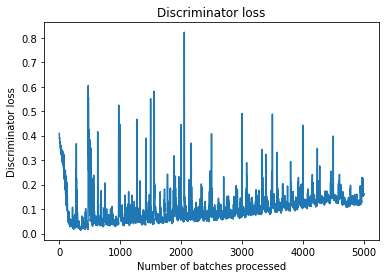

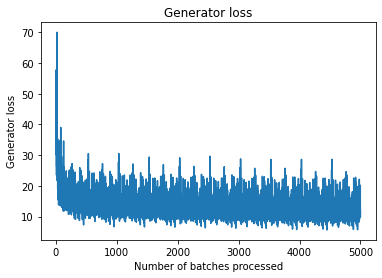

In [ ]:
plot_disc_loss(discriminator_losses)
plot_gen_loss(generator_losses)

Now let's test the model we obtained showing the generator output for one input image.


Let's try to save and load the models form disc. Anyway, they have been saved each 10 iterations during training.

In [ ]:
save_model(generator, generator_model_path, verbose=True)
save_model(discriminator, discriminator_model_path, verbose=True)

In [ ]:
generator = Generator(3)
load_model(generator, generator_model_path)

discriminator = Discriminator(in_channels=6, kernel_size=4)
load_model(discriminator, discriminator_model_path, verbose=True)

##Test

We will execute our generator on the first image of the training dataset, to see if it's working properly.

In [ ]:
# TEST
input_img, tg_img = dataset[0]
input_img = input_img.unsqueeze(0)
tg_img = tg_img.unsqueeze(0)

out = generator.forward(input_img)

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

In [ ]:
print('Input image:')
plot_image(input_img[0])

No we implement a function to calculate the test error of our model, its arguments are:
- <code>data</code>: <code>DataLoader</code> object with the test dataset.
- <code>g</code>: generator instance.
- <code>d</code>: discriminator instance.
- <code>g_l</code>: generator loss function.
- <code>d_l</code>: discriminator loss function
It will return the generator test error and the discriminator test error in a tuple.

In [ ]:
def get_test_error(data, g, d, g_l, d_l):
  gen_loss_return = 0.0
  dis_loss_return = 0.0
  
  for (input_img, tg_img) in data:

    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    generated_image = g(input_img)

    disc_inp_fake = torch.cat((input_img, generated_image), 1)

    discriminator_fake = d(disc_inp_fake.detach())
    discriminator_fake_loss = d_l(discriminator_fake, fake_target)

    disc_inp_real = torch.cat((input_img, target_img), 1)

    discriminator_real = d(disc_inp_real)
    discriminator_real_loss = d_l(discriminator_real,  real_target)

    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    dis_loss_return = dis_loss_return + discriminator_total_loss.item()

    fake_gen = torch.cat((input_img, generated_image), 1)
    
    discriminator_prediction = d(fake_gen)
    gen_loss = g_l(generated_image, tg_img, discriminator_prediction, real_target).item()                            

    gen_loss_return = gen_loss_return + gen_loss
  
  return gen_loss_return / len(data), dis_loss_return / len(data)

So the test error for our model are:

In [ ]:
print(get_test_error(dataloader_test, generator, discriminator, generator_loss, discriminator_loss))

(10.330827569961547, 0.15648712148269017)


## 6. Using additional perceptual losses (<code>torchmetrics</code>)


### Changes introduced

The first improvement we have implemented, <code>LearnedPerceptualImagePatchSimilarity</code>, is used to judge the perceptual similarity between two images. This loss will be added to the generator loss, to penalize those generated images that are not similar to their input images.

In [78]:
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

This way, we have to define a new generator loss adding the perceptual loss. We have decided to multiply its value by 50 to make it more important than the _adversarial_ loss but less than the _l1_ loss.

In [79]:
def generator_loss_lpips(generator_image, target_image, discriminator_predictions, real_target):
  gen_loss = adversarial_loss(discriminator_predictions, real_target)
  l1_l = l1_loss(generator_image, target_image)
  perceptual_similarity = lpips(generator_image, target_image)
  result = gen_loss + (100 * l1_l) + (50 * perceptual_similarity)

  return result

### Training

Let's create objects for a new generator, a new discriminator and their Adam optimizers.

In [ ]:
generator_lpips = Generator(3)
generator_lpips.to(device)
generator_optimizer_lpips = op.Adam(generator_lpips.parameters(), lr=0.0002, weight_decay=0.5)

discriminator_lpips = Discriminator(in_channels=6, kernel_size=4)
discriminator_lpips.to(device)
discriminator_optimizer_lpips = op.Adam(discriminator_lpips.parameters(), lr=0.0002, weight_decay=0.5)

Therefore, the training phase would follow as:

In [ ]:
generator_lpips_path = "drive/MyDrive/models/generatorModelImageColoringLpips.pth"
discriminator_lpips_path = "drive/MyDrive/models/discriminatorModelImageColoringLpips.pth"

generator_lpips_losses = list()
discriminator_lpips_losses = list()

num_epochs = 10
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    discriminator_optimizer_lpips.zero_grad()
    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    generated_image = generator_lpips(input_img)

    disc_inp_fake = torch.cat((input_img, generated_image), 1)

    discriminator_fake = discriminator_lpips(disc_inp_fake.detach())

    discriminator_fake_loss = discriminator_loss(discriminator_fake, fake_target)

    disc_inp_real = torch.cat((input_img, target_img), 1)

    discriminator_real = discriminator_lpips(disc_inp_real)
    discriminator_real_loss = discriminator_loss(discriminator_real,  real_target)

    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    discriminator_lpips_losses.append(discriminator_total_loss.item())

    discriminator_total_loss.backward()
    discriminator_optimizer_lpips.step()

    generator_optimizer_lpips.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = discriminator_lpips(fake_gen)

    # NEW: The generator loss has changed!
    gen_loss = generator_loss_lpips(generated_image, tg_img, discriminator_prediction, real_target)                              

    generator_lpips_losses.append(gen_loss.item())

    gen_loss.backward()
    generator_optimizer_lpips.step()

    if cnt % 10 == 0:
      print("CURRENT STATE: Epoch: {0}, Number of batches processed: {1}".format(epoch, cnt))
      save_model(generator_lpips, generator_lpips_path)
      save_model(discriminator_lpips, discriminator_lpips_path)
    
    cnt = cnt + 1

CURRENT STATE: Epoch: 1, Number of batches processed: 10
CURRENT STATE: Epoch: 1, Number of batches processed: 20
CURRENT STATE: Epoch: 1, Number of batches processed: 30
CURRENT STATE: Epoch: 1, Number of batches processed: 40
CURRENT STATE: Epoch: 1, Number of batches processed: 50
CURRENT STATE: Epoch: 1, Number of batches processed: 60
CURRENT STATE: Epoch: 1, Number of batches processed: 70
CURRENT STATE: Epoch: 1, Number of batches processed: 80
CURRENT STATE: Epoch: 1, Number of batches processed: 90
CURRENT STATE: Epoch: 1, Number of batches processed: 100
CURRENT STATE: Epoch: 1, Number of batches processed: 110
CURRENT STATE: Epoch: 1, Number of batches processed: 120
CURRENT STATE: Epoch: 1, Number of batches processed: 130
CURRENT STATE: Epoch: 1, Number of batches processed: 140
CURRENT STATE: Epoch: 1, Number of batches processed: 150
CURRENT STATE: Epoch: 1, Number of batches processed: 160
CURRENT STATE: Epoch: 1, Number of batches processed: 170
CURRENT STATE: Epoch: 1

The plots for the generator and discriminator loss are the following:

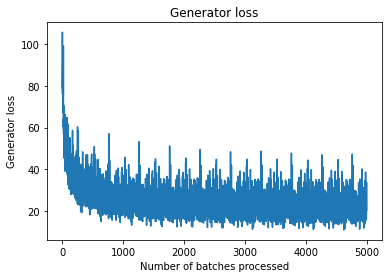

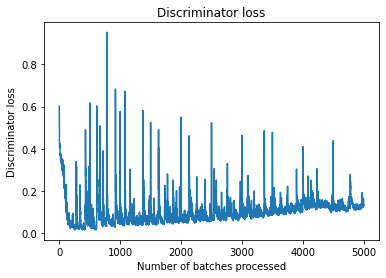

In [ ]:
plot_gen_loss(generator_lpips_losses)
plot_disc_loss(discriminator_lpips_losses)

### Test

Now let's test the model we obtained showing the generator output for training image.

In [ ]:
# TEST
input_img, tg_img = dataset[0]
input_img = input_img.unsqueeze(0)
tg_img = tg_img.unsqueeze(0)

out = generator_lpips.forward(input_img)

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

In [ ]:
print('Input image:')
plot_image(input_img[0])

The test errors for this new model are:

In [ ]:
print(get_test_error(dataloader_test, generator_lpips, discriminator_lpips, generator_loss, discriminator_loss))

(33.18053932189942, 0.3678408771753311)


##7. Using WGAN (with gradient penalty) as training mechanism


The Wassertstein Generative Adversarial Network (WGAN) is a variant of GAN propposed in 2017. It is usefull because produces higher model stability and the loss acquires meaning due to a termination criteria. It also prevents model collapse.

### Changes introduced

The WGAN architecture requires also implementing a gradient penalty function:

In [45]:
def compute_gp(discriminator, real_data, fake_data):
  
  batch_size = real_data.size(0)
  
  # Sample Epsilon from uniform distribution
  eps = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
  eps = eps.expand_as(real_data)
        
  # Interpolation between real data and fake data.
  interpolation = eps * real_data + (1 - eps) * fake_data
        
  # get logits for interpolated images
  interp_logits = discriminator(interpolation)
  grad_outputs = torch.ones_like(interp_logits)
        
  # Compute Gradients
  gradients = autograd.grad(
    outputs=interp_logits,
    inputs=interpolation,
    grad_outputs=grad_outputs,
    create_graph=True,
    retain_graph=True,
  )[0]
        
  # Compute and return Gradient Norm
  gradients = gradients.view(batch_size, -1)
  grad_norm = gradients.norm(2, 1)
  return torch.mean((grad_norm - 1) ** 2)

And we will also use another discriminator loss function:

In [46]:
def discriminator_loss_wgan(output, label, gradient_penalty, c_lambda=10):
  return torch.mean(output - label  + gradient_penalty * c_lambda)

### Training

In [69]:
CRITIC_ITERATIONS = 5

generator_wgan = Generator(3)
generator_wgan.to(device)
generator_optimizer_wgan = op.Adam(generator_wgan.parameters(), lr=0.0002, weight_decay=0.5)

critic_wgan = Discriminator(in_channels=6, kernel_size=4)
critic_wgan.to(device)
critic_optimizer_wgan = op.Adam(critic_wgan.parameters(), lr=0.0002, weight_decay=0.5)

In [88]:
generator_wgan_path = "drive/MyDrive/models/generatorModelImageColoringWGAN.pth"
discriminator_wgan_path = "drive/MyDrive/models/discriminatorModelImageColoringWGAN.pth"

generator_wgan_losses = list()
discriminator_wgan_losses = list()

num_epochs = 10
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    critic_optimizer_wgan.zero_grad()

    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    generated_image = generator_wgan(input_img)

    # NEW: discriminator will be updated CRITIC_ITERATIONS each batch processed
    for _ in range(CRITIC_ITERATIONS):

      disc_inp_fake = torch.cat((input_img, generated_image), 1)
      discriminator_fake = critic_wgan(disc_inp_fake.detach())
      
      disc_inp_real = torch.cat((input_img, tg_img), 1)
      discriminator_real = critic_wgan(disc_inp_real)

      # NEW: we are calculating the gradient penalty
      gradient_penalty = compute_gp(critic_wgan, disc_inp_real, disc_inp_fake)

      # NEW: the discriminator loss has changed
      discriminator_fake_loss = discriminator_loss_wgan(discriminator_fake, fake_target, gradient_penalty)
      discriminator_real_loss = discriminator_loss_wgan(discriminator_real,  real_target, gradient_penalty)
      
      discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

      discriminator_wgan_losses.append(discriminator_total_loss.item())

      discriminator_total_loss.backward(retain_graph=True)
      critic_optimizer_wgan.step()

    generator_optimizer_wgan.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = critic_wgan(fake_gen)
    
    gen_loss = generator_loss(generated_image, tg_img, discriminator_prediction, real_target)

    generator_wgan_losses.append(gen_loss.item())

    gen_loss.backward(retain_graph=True)
    generator_optimizer_wgan.step()

    if cnt % 10 == 0:
      print("CURRENT STATE: Epoch: {0}, Number of batches processed: {1}".format(epoch, cnt))
      save_model(generator_wgan, generator_wgan_path)
      save_model(critic_wgan, discriminator_wgan_path)
    
    cnt = cnt + 1

CURRENT STATE: Epoch: 1, Number of batches processed: 10


The plots for the generator and discriminator loss are the following:

In [49]:
plot_gen_loss(generator_wgan_losses)
plot_disc_loss(discriminator_wgan_losses)

NameError: ignored

### Test

Now let's test the model we obtained showing the generator output for training image.

Generated image:


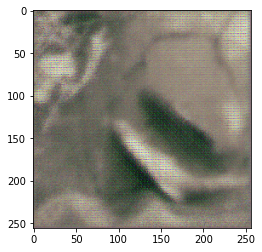

In [89]:
# TEST
input_img, tg_img = dataset[0]
input_img = input_img.unsqueeze(0)
tg_img = tg_img.unsqueeze(0)

out = generator_wgan.forward(input_img)

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

Input image:


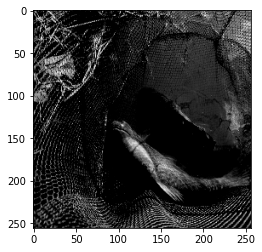

In [51]:
print('Input image:')
plot_image(input_img[0])

The test errors for this new model are:

In [ ]:
print(get_test_error(dataloader_test, generator_wgan, discriminator_wgan, generator_loss, discriminator_loss))

(30.79624843597412, 1.2965497732162476)


##7. Using WGAN and additional perceptual losses


###Training

On this occasion, not only will we be training our former WGAN network but we will also introduce our <code>generator_loss_lpips</code> previously created.

In [73]:
generator_all = Generator(3)
generator_all.to(device)
generator_optimizer_all = op.Adam(generator_all.parameters(), lr=0.0002, weight_decay=0.5)

critic_all = Discriminator(in_channels=6, kernel_size=4)
critic_all.to(device)
critic_optimizer_all = op.Adam(critic_all.parameters(), lr=0.0002, weight_decay=0.5)

In [82]:
generator_all_path = "drive/MyDrive/models/generatorModelImageColoringWGANandLpips.pth"
discriminator_all_path = "drive/MyDrive/models/discriminatorModelImageColoringWGANandLpips.pth"

generator_all_losses = list()
discriminator_all_losses = list()

num_epochs = 10
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    critic_optimizer_all.zero_grad()

    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    generated_image = generator_all(input_img)

    for _ in range(CRITIC_ITERATIONS):

      disc_inp_fake = torch.cat((input_img, generated_image), 1)
      discriminator_fake = critic_all(disc_inp_fake.detach())
      
      disc_inp_real = torch.cat((input_img, tg_img), 1)
      discriminator_real = critic_all(disc_inp_real)

      gradient_penalty = compute_gp(critic_all, disc_inp_real, disc_inp_fake)

      discriminator_fake_loss = discriminator_loss_wgan(discriminator_fake, fake_target, gradient_penalty)
      discriminator_real_loss = discriminator_loss_wgan(discriminator_real,  real_target, gradient_penalty)

      discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

      discriminator_all_losses.append(discriminator_total_loss.item())

      discriminator_total_loss.backward(retain_graph=True)
      critic_optimizer_all.step()

    generator_optimizer_all.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = critic_all(fake_gen)

    gen_loss = generator_loss_lpips(generated_image, tg_img, discriminator_prediction, real_target)                              

    generator_all_losses.append(gen_loss.item())

    gen_loss.backward(retain_graph=True)
    generator_optimizer_all.step()

    if cnt % 10 == 0:
      print("CURRENT STATE: Epoch: {0}, Number of batches processed: {1}".format(epoch, cnt))
      save_model(generator_all, generator_all_path)
      save_model(critic_all, discriminator_all_path)
    
    cnt = cnt + 1

CURRENT STATE: Epoch: 1, Number of batches processed: 10


The plots for the generator and discriminator loss are the following:

In [ ]:
plot_gen_loss(generator_all_losses)
plot_disc_loss(discriminator_all_losses)

###Test

Generated image:


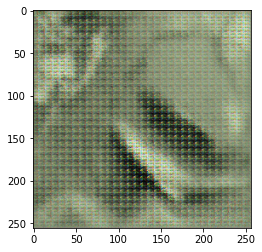

In [83]:
# TEST
input_img, tg_img = dataset[0]
input_img = input_img.unsqueeze(0)
tg_img = tg_img.unsqueeze(0)

out = generator_all.forward(input_img)

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

The test errors for this new model are:

In [84]:
print(get_test_error(dataloader_test, generator_all, critic_all, generator_loss, discriminator_loss))

NameError: ignored